# 9. 비지도 학습

9장은 **입력 정보만 사용**하는 **비지도 학습**입니다. 그 중 **클러스터링**에 대해서 배워보겠습니다.

## 9.1 2차원 입력 데이터

6장 클래스 분류에서 다룬 2차원 입력 데이터 X를 사용하지만, 비지도 학습 문제는 라벨 데이터 T는 사용하지 않습니다. **라벨 정보 없이, 입력 데이터가 비슷한 것끼리 나누는 것**이 **클러스터링**입니다.

<ipython-input-1-226519917b5b>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] + Mu[T3[n, :] == 1, k])


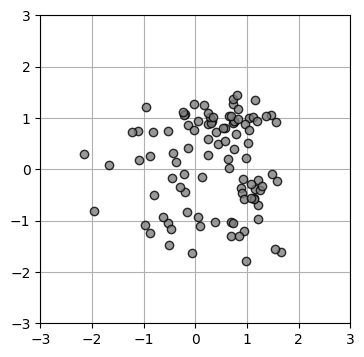

In [ ]:
# 리스트 9-1-(1)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 생성 --
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype = np.uint8)
X  = np.zeros((N, 2))

X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']

Mu  = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi  = np.array([0.4, 0.8, 1]) # 누적 확률

for n in range(N) :
  wk = np.random.rand()

  for k in range(K) :
    if wk < Pi[k] :
      T3[n, k] = 1
      break
  for k in range(2) :
    X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] + Mu[T3[n, :] == 1, k])

# 데이터를 그리기
def show_data(x) :
  plt.plot(x[:, 0], x[:, 1], linestyle = 'none', marker = 'o', markersize = 6, markeredgecolor = 'black', color = 'gray', alpha = 0.8)
  plt.grid(True)

# 메인 ----
plt.figure(1, figsize = (4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X = X, X_range0 = X_range0, X_range1 = X_range1)

위의 그래프는 입력 데이터 X의 분포를 T에 의한 색깔 구분 없이 나타낸 것입니다. 색깔 구분이 없어도 분포의 경향을 알 수 있습니다. x0=0.5, x1=1 부근과 x0=1, x1=-0.5에 데이터가 모여있습니다. 이러한 **데이터 분포의 모양**을 **Cluster**라고 합니다. 데이터 분포에서 클러스터를 찾아, 동일한 클러스터에 속하는 **데이터 점에**는 같은 라벨을 붙이고, 다른 클러스터에 속하는 데이터 점에는 다른 **라벨을 할당하는 것**이 **클러스터링**입니다.

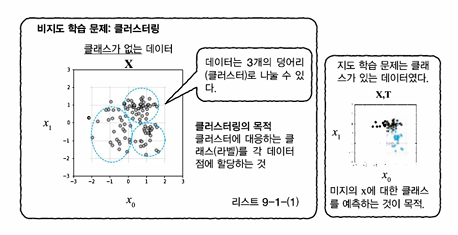

동일한 클러스터에 속하는 데이터 점은 '닯았다'고 간주되고, 다른 클러스터에 속한 데이터 점은 '닮지 않은 것'으로 간주됩니다.

클러스팅에 가장 많이 사용되는 K-means 기법을 알아보겠습니다.

## 9.2 K-means 기법

K-means 기법은 미리 분할할 **클러스터의 수 K**를 결정해야 합니다. 이 예제에서는 3개의 클러스터로 분류합니다.

K-means 기법에서는 두 변수를 사용합니다. 하나는 클러스터의 중심 벡터 **µ**로, **클러스터의 중심 위치**를 나타냅니다. 다른 하나는 클래스 변수 **R**이며, **각 데이터 점이 어떤 클러스터에 속하는지**를 나타냅니다.

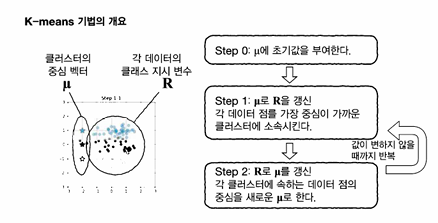

가장 먼저 중심 벡터 µ를 적절한 값으로 초기화(Step0)합니다.
그 다음엔 현시점에서의 µ로, R을 결정(Step1)합니다. 그리고 현 시점에서 클래스 지시 변수 R로 µ를 갱신(Step2)합니다. 이후엔 Step1과 Step2를 반복하여, µ와 R를 갱신합니다. 그리고 이 두 개의 값이 변화하지 않으면 종료합니다.

### 9.2.2 Step 0: 변수의 준비와 초기화

k 번째 클러스터의 중심 벡터는 다음과 같이 나타냅니다.

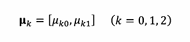

각 데이터 점에 대한 라벨 R은 one-hot encoding으로 나타냅니다. 1이 데이터가 라벨에 속하는 경우를 나타냅니다.

모든 데이터 n에 대한 클래스 지시 변수를 행렬로 나타내면 다음과 같습니다.

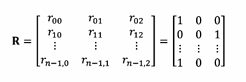

In [ ]:
# 리스트 9-1-(2)
# Mu 및 R 초기화 ----
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) #(A)
R = np.c_[np.ones((N, 1), dtype = int), np.zeros((N, 2), dtype = int)] # (B)

이 예에선 K=3이므로 3개의 중심 벡터를 생성합니다. 이는 µ0=[-2,1],µ1=[-2,0], µ0=[-2,-1]로 초기화했습니다.

(B)에선 모든 데이터가 클래스 0에 속하도록 R을 초기화 했지만, R은 µ로 갱신되기 때문에 어떻게 초기화 하든 알고리즘에 영향이 없습니다.

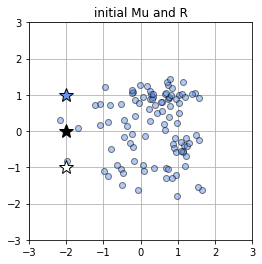

In [ ]:
# 리스트 9-1-(3)
# 데이터를 그리는 함수 ----
def show_prm(x, r, mu, col) :
  for k in range(K) :
    # 데이터 분포의 묘사
    plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1], marker = 'o', markerfacecolor = X_col[k], markeredgecolor = 'k', markersize = 6, alpha = 0.5, linestyle = 'none')
    # 데이터의 평균을 "별표"로 묘사
    plt.plot(mu[k, 0], mu[k, 1], marker = '*', markerfacecolor = X_col[k], markersize = 15, markeredgecolor = 'k', markeredgewidth = 1)

  plt.xlim(X_range0)
  plt.ylim(X_range1)
  plt.grid(True)

# ----
plt.figure(figsize = (4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

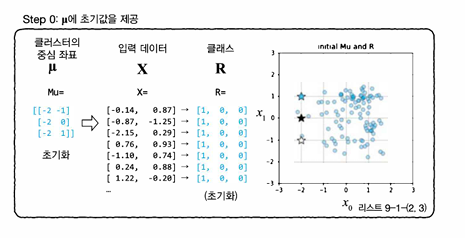

클러스터의 중심좌표 µ와 모든 데이터에 대한 클래스 R을 초기화 한 그림입니다.

### 9.2.3 Step 1: R의 갱신

이제 R을 갱신합니다. 갱신 방법은 "각 데이터 점을 중심이 가까운 클러스터에 넣는 것."입니다.

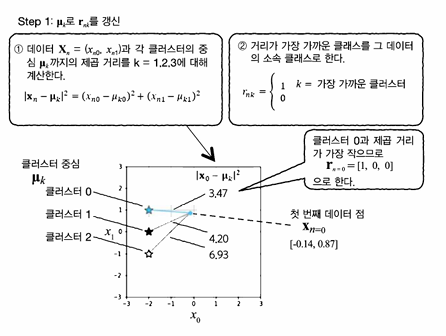

데이터 점이 있을 때, 각 클래스의 중심위치인 µ0, µ1, µ2와의 거리를 계산하여 가장 가까운 클래스를 그 데이터에 소속 클래스로 정합니다. 위의 그림에서는 데이터가 가장 가까운 클래스 0에 속하게 된 것을 볼 수 있습니다.

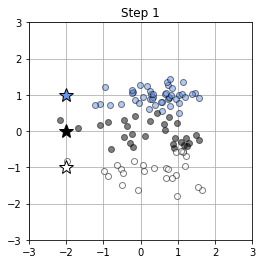

In [ ]:
# 리스트 9-1-(4)
# r을 결정한다 (step 1) ----
def step1_kmeans(x0, x1, mu) :
  N = len(x0)
  r = np.zeros((N, K))

  for n in range(N) :
    wk = np.zeros(K)
    for k in range(K) :
      wk[k] = (x0[n] - mu[k, 0]) ** 2 + (x1[n] - mu[k, 1]) ** 2
    r[n, np.argmin(wk)] = 1
  return r

# ----
plt.figure(figsize = (4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

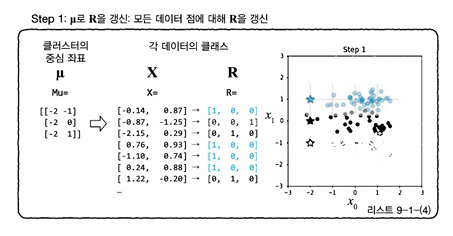

데이터 점들이 각 클래스의 중심좌표인 µ와 계산되어 클래스가 배정된 것을 볼 수 있습니다.

### 9.2.4 Step 2: μ의 갱신

다음은 µ를 갱신합니다. 갱신 방법은 "각 클러스터에 속하는 데이터 점의 중심을 µ로 한다"입니다.

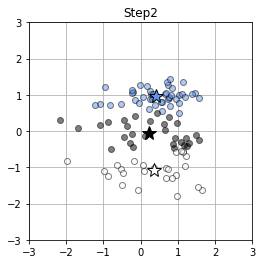

In [ ]:
# 리스트 9-1-(5)
# Mu 결정 (Step 2) ----
def step2_kmeans(x0, x1, r) :
  mu = np.zeros((K, 2))
  for k in range(K) :
    mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
    mu[k, 1] = np.sum(r[:, k] * x1) /np.sum(r[:, k])
  return mu

# ----
plt.figure(figsize = (4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

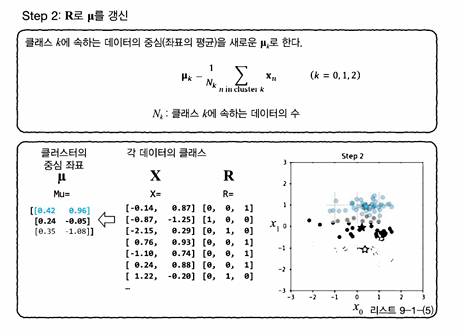

위 그림에서 µ가 각 클러스터 중심으로 이동한 것을 볼 수 있습니다.

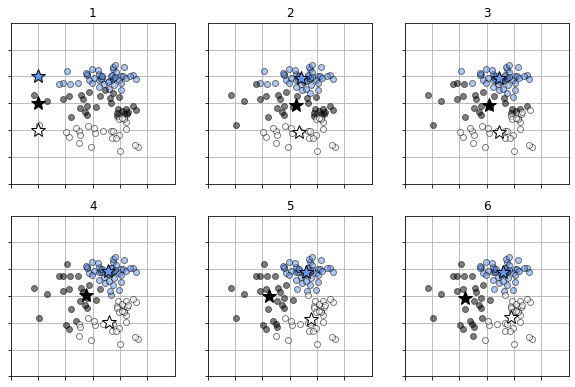

In [ ]:
# 리스트 9-1-(6)
plt.figure(1, figsize = (10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])

max_it = 6 # 반복 횟수
for it in range(0, max_it) :
  plt.subplot(2, 3, it + 1)
  R = step1_kmeans(X[:, 0], X[:, 1], Mu)
  show_prm(X, R, Mu, X_col)

  plt.title("{0:d}".format(it + 1))
  plt.xticks(range(X_range0[0], X_range0[1]), "")
  plt.yticks(range(X_range1[0], X_range1[1]), "")
  Mu = step2_kmeans(X[:, 0], X[:, 1], R)

plt.show()

이후에는 Step1(데이터의 클래스 R 갱신)과 Step2(클래스의 중심 좌표 µ 갱신)의 절차를 반복합니다. 그리고 변수의 값이 변화하지 않으면 프로그램을 종료합니다. 이 예에서는 6회 반복 이후 그래프의 변화가 멈추었습니다.

### 9.2.5 왜곡 척도

비지도 학습의 오차는 **왜곡 척도**를 통해 알 수 있습니다. 이는 데이터 점이 속한 클러스터의 중심까지의 제곱 거리를, 모두 더한 값을 사용합니다. 식으로 나타내면 다음과 같습니다.

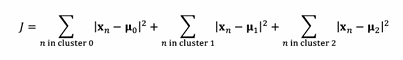


In [ ]:
# 리스트 9-1-(7)
# 목적 함수 ----
def distortion_measure(x0, x1, r, mu) :
  # 입력은 2차원으로 제한하고 있다
  N = len(x0)
  J = 0
  for n in range(N) :
    for k in range(K) :
      J = J + r[n, k] * ((x0[n] - mu[k, 0]) ** 2 + (x1[n] - mu[k, 1]) ** 2)
  return J

# ---- test
# ---- Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R  = np.c_[np.ones((N, 1), dtype = int), np.zeros((N, 2), dtype = int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


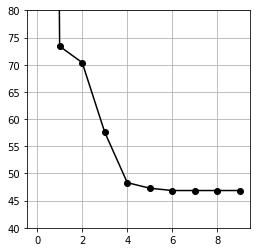

In [ ]:
# 리스트 9-1-(8)
# Mu와 R의 초기화
N = X.shape[0]
K = 3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R  = np.c_[np.ones((N, 1), dtype = int), np.zeros((N, 2), dtype = int)]

max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과를 넣는다

for it in range(0, max_it) : # K-means 법
  R = step1_kmeans(X[:, 0], X[:, 1], Mu)
  DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
  Mu = step2_kmeans(X[:, 0], X[:, 1], R)

print(np.round(DM, 2))
plt.figure(2, figsize = (4, 4))
plt.plot(DM, color = 'black', linestyle = '-', marker = 'o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

µ를 초기값으로 되돌려 왜곡 척도를 계산합니다. 초기값에 대해선 오차가 771.7이 나왔습니다. R과 µ가 갱신됨에 따라 왜곡 척도의 값이 줄어듦을 볼 수 있습니다.

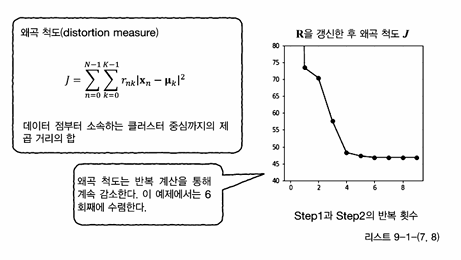

초기 µ 값에 따라 결과값이 달라질 수 있습니다. 다양한 µ에서 시작하여 얻은 값 중 가장 왜곡 척도가 작은 것을 클러스터링에 사용합니다.

## 9.3 가우시안 혼합 모델

###  9.3.1 확률적 클러스터링

가우시안 혼합 모델을 이용해 확률적 클러스터링을 합니다.

"데이터 점 A는 확실히 0에 속하지만, 점 B는 클러스터 0과 1에 모두 속해 있다"는 **모호성을 수치화**할 때 사용합니다.

예를 들어, 점 A가 클러스터 0에 속할 확률은 0.9이며, 클러스터 1과 2에 속할 확률은 각각 0.1, 0.0이라고 합시다. 이것을 **감마**를 사용하여 다음과 같이 나타냅니다.

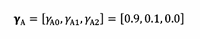

어떤 쪽의 클러스터에는 반드시 속해야 하기 때문에 3개의 **확률을 더하면 1**이 됩니다.

예를 들어 2차원 입력 데이터 x = [x0, x1]은 곤충의 질량과 크기를 나타낸다고 합시다. 같은 종류의 곤충 200 마리를 질량과 크기로 플롯했을 때, 3개의 클러스터가 나타났다고 합시다.

외형이 같아 같은 종류로 수집했던 곤충이 세 가지 변종이 있음을 보였습니다. 이렇게 **관찰은 못했지만 데이터에 영향을 준 변수**를 **잠재 변수**라고 합니다. 이 잠재 변수를 3차원 벡터를 사용해 one-hot encoding 하면 다음과 같습니다.

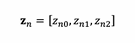

데이터 n이 클래스 k에 속한다면 z_nk만 1을 취하고, 다른 요소는 0으로 합니다. 이는 K-means 기법의 R과 유사합니다. 그러나 여기에는 '잠재 변수'라는 뉘앙스를 강조하기 위해 Z로 나타냅니다.

'데이터 n이 클러스터 k에 속할 확률 γ_nk란 데이터 x_n인 곤충이 클래스 k의 변종일 확률'을 의미합니다. 수식으로 나타내면 다음과 같습니다.

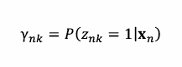

즉, "관찰할 수 없는 Z의 추정치가 γ이다"라고 말할 수 있습니다. Z는 "어떤 클래스에 속하고 있는가"라는 의미로, 0 또는 1 값을 갖지만, γ는 확률적인 추정값이므로 0과 1 사이의 실수 값을 취합니다. 이 γ는 "어떤 클러스터에 얼마나 기여하고 있는가"라는 의미에서 부담률이라고 합니다.

정리하면 **확률적 클러스터링**은 **데이터에 숨어있는 잠재 변수 Z를 확률적으로 γ로 추정하는 것**입니다.

**부담률 γ를 구하기 위한 모델**이 **가우시안 혼합 모델**입니다.

### 9.3.2 가우시안 혼합 모델

가우시안 혼합 모델은 4장에서 설명한 2차원 가우스 함수 여러 개를 합친 것입니다. 식은 다음과 같습니다.

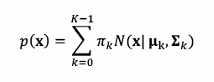
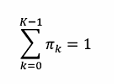

매개변수는 µ_k와 Σ_k, π_k로, 각각 평균과 분포의 퍼짐을 나타내는 공분산 행렬, 분포의 크기 비율을 나타냅니다. 혼합 계수 π_k는 0과 1 사이의 실수로, K로 합을 취했을 때 1이 되어야 합니다.

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# 리스트 9-2-(1)
import numpy as np
wk = np.load('data_ch9.npz')
X = wk['X']

X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

In [ ]:
# 리스트 9-2-(2)
# 가우스 함수 ----
# x: N*D의 데이터 행렬, mu: 길이가 D인 중심 벡터, sigma: D*D의 공분산 행렬
def gauss(x, mu, sigma) :
  N, D = x.shape
  c1 = 1 / (2 * np.pi) ** (D / 2)
  c2 = 1 / (np.linalg.det(sigma) ** (1 / 2))

  inv_sigma = np.linalg.inv(sigma)
  c3 = x - mu
  c4 = np.dot(c3, inv_sigma)
  c5 = np.zeros(N)

  for d in range(D) :
    c5 = c5 + c4[:, d] * c3[:, d]

  p = c1 * c2 * np.exp(-c5 / 2)
  return p

In [ ]:
# 리스트 9-2-(3)
# N=3, D(입력 벡터의 길이)=2
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


In [ ]:
# 리스트 9-2-(4)
# 혼합 가우시안 모델 ----
# x: N*D의 데이터 행렬, pi: 길이 K의 벡터
# mu: K*D의 행렬로 K개의 가우스 함수 중심 벡터, sigma: K*D*D의 3차원 배열로 K개의 가우스 함수 공분산 행렬
def mixgauss(x, pi, mu, sigma) :
  N, D = x.shape
  K = len(pi)
  p = np.zeros(N)
  for k in range(K) :
    p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
  return p

In [ ]:
# 리스트 9-2-(5)
# test ----
# N=3, D=2, K=2
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])

print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [ ]:
# 리스트 9-2-(6)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

# 혼합 가우스 등고선 표시 ----
def show_contour_mixgauss(pi, mu, sigma) :
  xn = 40 # 등고선 표시 해상도
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)

  x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] # 1 -> 'F'
  f = mixgauss(x, pi, mu, sigma)
  f = f.reshape(xn, xn)
  f = f.T
  plt.contour(x0, x1, f, 10, colors = 'gray')

# 혼합 가우스 3D 표시 ----
def show3d_mixgauss(ax, pi, mu, sigma) :
  xn = 40 # 등고선 표시 해상도
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)

  x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')] # 1 -> 'F'
  f = mixgauss(x, pi, mu, sigma)
  f = f.reshape(xn, xn)
  f = f.T
  ax.plot_surface(xx0, xx1, f, rstride = 2, cstride = 2, alpha = 0.3, color = 'blue', edgecolor = 'black')

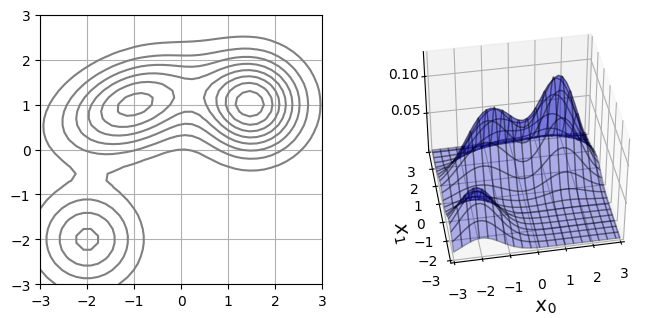

In [ ]:
# 리스트 9-2-(7)
# test ----
# D=2, K=3
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array([[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])

Fig = plt.figure(1, figsize = (8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)

Ax = Fig.add_subplot(1, 2, 2, projection = '3d')
show3d_mixgauss(Ax, pi, mu, sigma)

Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize = 14)
Ax.set_ylabel('$x_1$', fontsize = 14)

Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

입력 벡터의 크기 D=2, 가우스 함수의 개수 K=3으로 분포를 그린 모습입니다.

### 9.3.3 EM 알고리즘의 개요

가우시안 혼합 모델을 사용하여 데이터의 클러스터링을 수행합니다. 여기에서는 **EM 알고리즘**을 사용하여 **가우시안 혼합 모델을 데이터에 피팅**해보고, **부담률 γ를 구하는 방법**을 설명합니다. 이 방법은 K-means 기법을 확장한 방법으로 해석할 수 있습니다.

EM 알고리즘과 K-means 기법의 차이는 다음과 같습니다.
K-means 기법에서는 각 클러스터의 중심 벡터를 µ로 특정했지만, 가우시안 혼합 모델은 중심 벡터 µ뿐만 아니라 공분산 행렬 Σ에 의해 각 클러스터의 확산 정도를 기술합니다. 또한 혼합 계수 π에 의해 각 클러스터의 크기 차이를 설명합니다. 그리고 K-means의 출력은 one-hot encoding의 클래스 R이었지만, 가우시안 혼합 모델은 각 클래스에 속할 확률에 대응하는 부담률 γ를 출력합니다.

**입력 매개변수**

K-means: µ (클러스터 중심 벡터)

EM 알고리즘: µ (클러스터 중심 벡터), Σ (클러스터의 확산 정도), π (클러스터 크기)

**출력**

k-means: R (one-hot encoding 클래스)

EM 알고리즘: γ (클래스에 속할 확률)

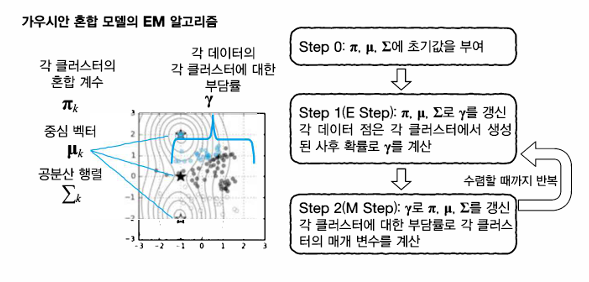

EM 알고리즘은 가장 먼저 µ, Σ, π를 초기화(Step0) 합니다. 그 다음 현 시점의 µ, Σ, π를 사용하여 γ(Step1)를 구합니다. 그 이후엔 현 시점의 γ를 이용하여 µ, Σ, π(Step2)를 구합니다. 매개변수가 수렴할 때까지 Step1과 Step2 과정을 반복합니다.

Step1을 Expectation의 E를 따서 E step, Step2를 Maximazation의 M을 따서 M Step이라고 합니다.

### 9.3.4 Step 0: 변수의 준비 및 초기화

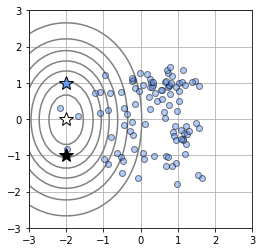

In [ ]:
# 리스트 9-2-(8)
# 초기설정 ----
# D=2
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]

X_col = np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])

# 데이터를 그리기 ----
def show_mixgauss_prm(x, gamma, pi, mu, sigma) :
  N, D = x.shape
  show_contour_mixgauss(pi, mu, sigma)

  for n in range(N) :
    col = gamma[n, 0] * X_col[0] + gamma[n, 1] * X_col[1]+ gamma[n, 2] * X_col[2]
    plt.plot(x[n, 0], x[n, 1], 'o', color = tuple(col), markeredgecolor = 'black', markersize = 6, alpha = 0.5)

  for k in range(K) :
    plt.plot(mu[k, 0], mu[k, 1], marker = '*', markerfacecolor = tuple(X_col[k]), markersize = 15, markeredgecolor = 'k', markeredgewidth = 1)

  plt.grid(True)

plt.figure(1, figsize = (4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

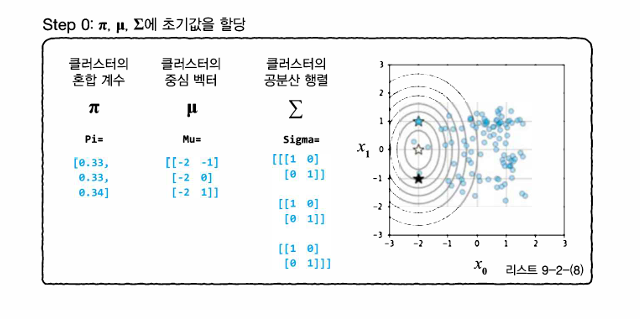

초기값으로 할당한 중심 벡터가 인접해 있어 3개의 가우스 함수가 겹쳐 세로로 긴 산과 같은 분포가 나타나 있는 모습입니다.

### 9.3.5 Step 1(E Step): γ 갱신

In [ ]:
# 리스트 9-2-(9)
# gamma 갱신 (E step) ----
def e_step_mixgauss(x, pi, mu, sigma):
  N, D = x.shape
  K = len(pi)
  y = np.zeros((N, K))

  for k in range(K) :
    y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN

  gamma = np.zeros((N, K))

  for n in range(N) :
    wk = np.zeros(K)
    for k in range(K) :
      wk[k] = pi[k] * y[n, k]
    gamma[n, :] = wk / np.sum(wk)
  return gamma

# 메인 ----
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

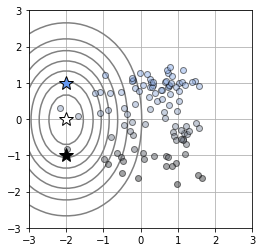

In [ ]:
# 리스트 9-2-(10)
# 표시 ----
plt.figure(1, figsize = (4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

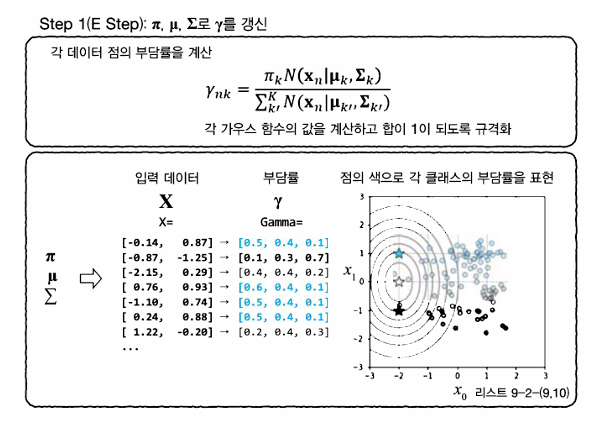

E Step입니다. 어떤 데이터 점 n에 착안했을 때, 그 데이터 점에서의 각 가우스 함수의 높이 a_k를 구합니다. 그리고 k에서 합을 취해 1이 되도록 a_k의 총합으로 나누어 γ_nk를 구합니다. '가우스 함수의 값이 높을수록 부담률도 높아진다'는 직관적인 방법입니다.

### 9.3.6 Step 2(M Step): π, μ, ∑ 의 갱신

In [ ]:
# 리스트 9-2-(11)
# Pi, Mu, Sigma 갱신(M Step) ----
def m_step_mixgauss(x, gamma) :
  N, D = x.shape
  N, K = gamma.shape
  # pi를 계산
  pi = np.sum(gamma, axis = 0) / N

  # mu을 계산
  mu = np.zeros((K, D))
  for k in range(K) :
    for d in range(D) :
      mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])

  # sigma를 계산
  sigma = np.zeros((K, D, D))
  for k in range(K) :
    for n in range(N) :
      wk = x - mu[k, :]
      wk = wk[n, :, np.newaxis]
      sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
    sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
  return pi, mu, sigma

# 메인 ----
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

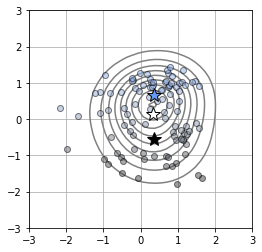

In [ ]:
# 리스트 9-2-(12)
# 표시 ----
plt.figure(1, figsize = (4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

다음은 M step입니다. 우선 각 클러스터에 대한 부담률의 합 N_k를 구합니다.

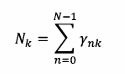

위에서 구한 N_k를 바탕으로 π_k를 갱신합니다. 여기서 N은 전체 데이터 수입니다.

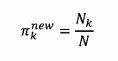

그리고 중심 벡터 µ_k를 다음과 같이 갱신합니다.

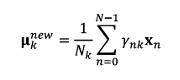

그리고 마지막으로, 가우스의 공분산 행렬을 갱신합니다. 갱신식에는 위에서 계산한 µ_k가 사용됩니다.

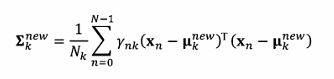

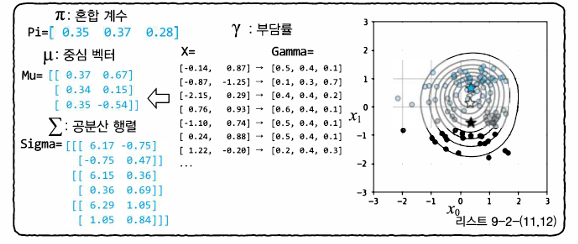

중심 벡터를 나타내는 별표가 클러스터 중심으로 이동한 것을 확인할 수 있습니다.

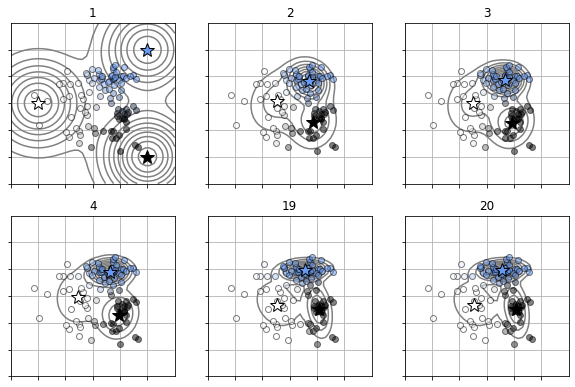

In [ ]:
# 리스트 9-2-(13)
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])

Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize = (10, 6.5))
max_it = 20 # 반복 횟수

i_subplot = 1;
for it in range(0, max_it) :
  Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

  if it < 4 or it > 17 :
    plt.subplot(2, 3, i_subplot)
    show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)

    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    i_subplot = i_subplot + 1
  Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

plt.show()

E Step과 M Step을 20번 반복한 결과입니다. 파란색, 흰색, 검은색이 각 클러스터를 나타냅니다. 클러스터의 경계 부근은 색이 섞인 모습을 볼 수 있습니다. 또한 클러스터링 결과는 K-means 기법과 마찬가지로 매개 변수의 초기값에 따라 달라집니다.

클러스터링의 오차를 평가하기 위해 K-means 경우에는 왜곡 척도를 사용했습니다. 가우시안 혼합 모델에서는 '가능도 함수'를 통해 오차를 확인합니다.

### 9.3.7 가능도

가우시안 혼합 모델은 데이터 분포 p(x)를 나타내는 모델입니다. **입력 데이터 X의 분포에 맞게 매개 변수를 갱신하였습니다**. 입력 데이터가 많은 부분에 가우스 함수가 배치되어, 입력 데이터가 적은 부분은 분포의 값이 낮도록 매개 변수를 조정한 것입니다. 각 가우스 분포가 다른 클러스터를 나타내게 된 것입니다.

그렇다면 EM 알고리즘의 목적 함수는 무엇일까요? 그것은 가능도 함수입니다. 즉 입력 데이터 X는 가우시안 혼합 모델에서 생성된 것으로 생각하여, X가 생성된 확률(가능도)이 가장 높도록 매개 변수를 갱신하는 것입니다. EM 알고리즘에서 각 매개 변수는 이 가능도를 최대로 하는 최대가능도 추정법을 이용합니다.
가능도 함수는 모든 데이터 점 X가 모델에서 생성된 확률이므로 다음과 같이 표현됩니다.

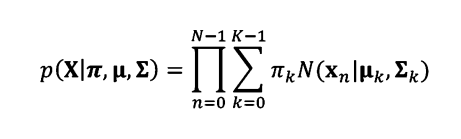

가능도 함수를 최대로 하는 값은 로그를 취해도 같기 때문에 계산이 용이한 로그 가능도 함수를 이용합니다. 또한, 최적화 과정에선 최솟값을 구하기 때문에 -1을 곱해 음의 로그 가능도 함수를 이용합니다.

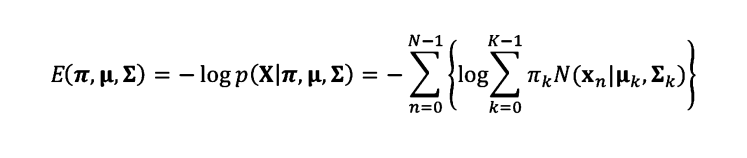

매개 변수를 다시 초기화한 후, 알고리즘 갱신 단계에서 오차 함수 E(π,µ,Σ)가 감소하는지 확인합니다.

In [ ]:
# 리스트 9-2-(14)
# 혼합 가우스의 목적 함수 ----
def nlh_mixgauss(x, pi, mu, sigma) :
  # x  : NxD
  # pi : Kx1
  # mu : KxD
  # sigma : KxDxD
  # output lh : NxK
  N, D = x.shape
  K = len(pi)
  y = np.zeros((N, K))

  for k in range(K) :
    y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN

  lh = 0
  for n in range(N) :
    wk = 0
    for k in range(K) :
      wk = wk + pi[k] * y[n, k]
    lh = lh + np.log(wk)
  return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


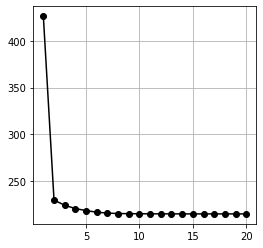

In [ ]:
# 리스트 9-2-(15)
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]

max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it) :
  Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
  Err[it] = nlh_mixgauss(X, Pi, Mu, Sigma)
  Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

print(np.round(Err, 2))

plt.figure(2, figsize = (4, 4))
plt.plot(np.arange(max_it) + 1, Err, color = 'k', linestyle = '-', marker = 'o')

plt.grid(True)
plt.show()

음의 로그 가능도 함수가 점차 감소해 step 10 정도에서 대부분 수렴한 것을 확인할 수 있습니다.